In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("/content/drive/MyDrive/Time Series Datasets")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

In [ ]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [ ]:
tunnel1 = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel1.head()

,Day,NumVehicles
0,2003-11-01,103536
1,2003-11-02,92051
2,2003-11-03,100795
3,2003-11-04,102352
4,2003-11-05,106569


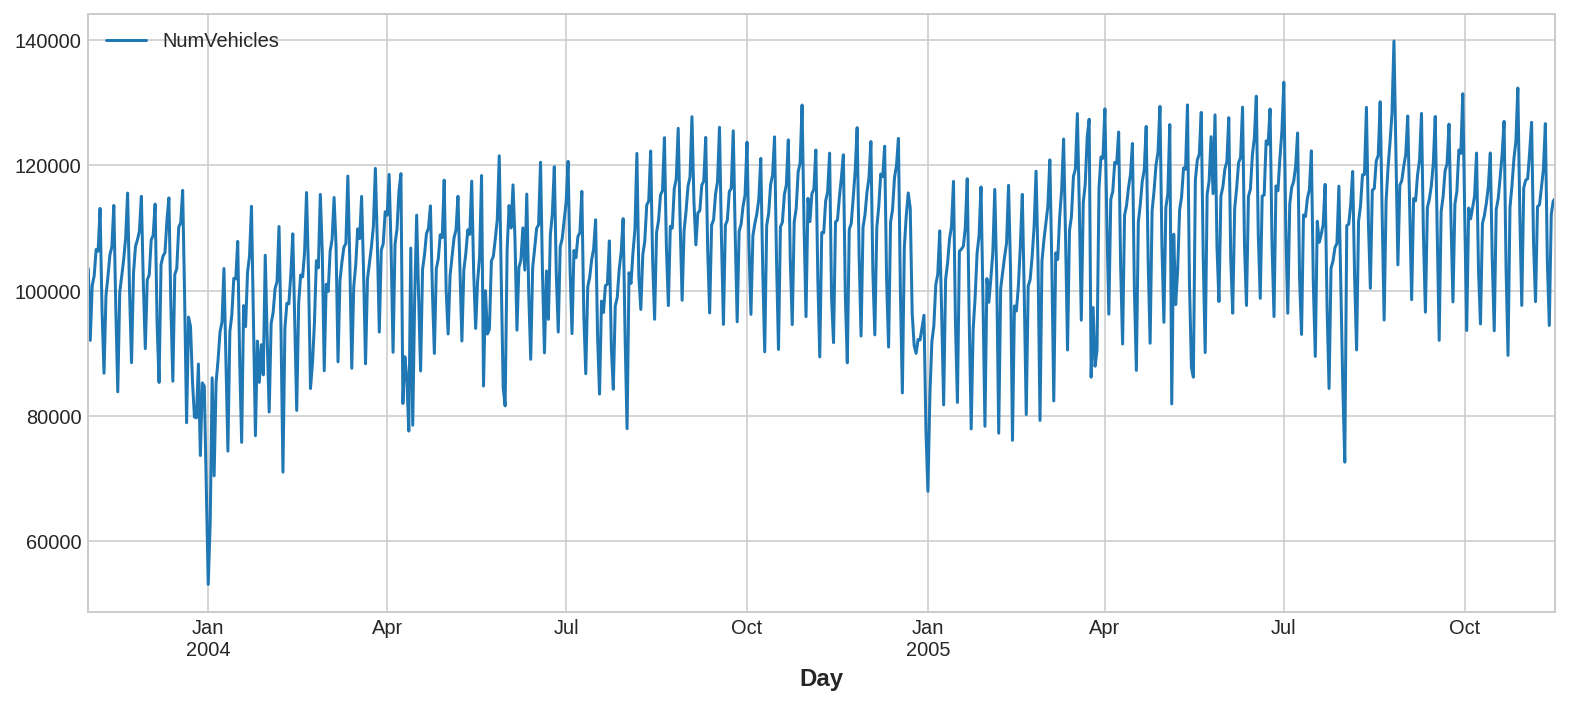

In [ ]:
tunnel.plot()

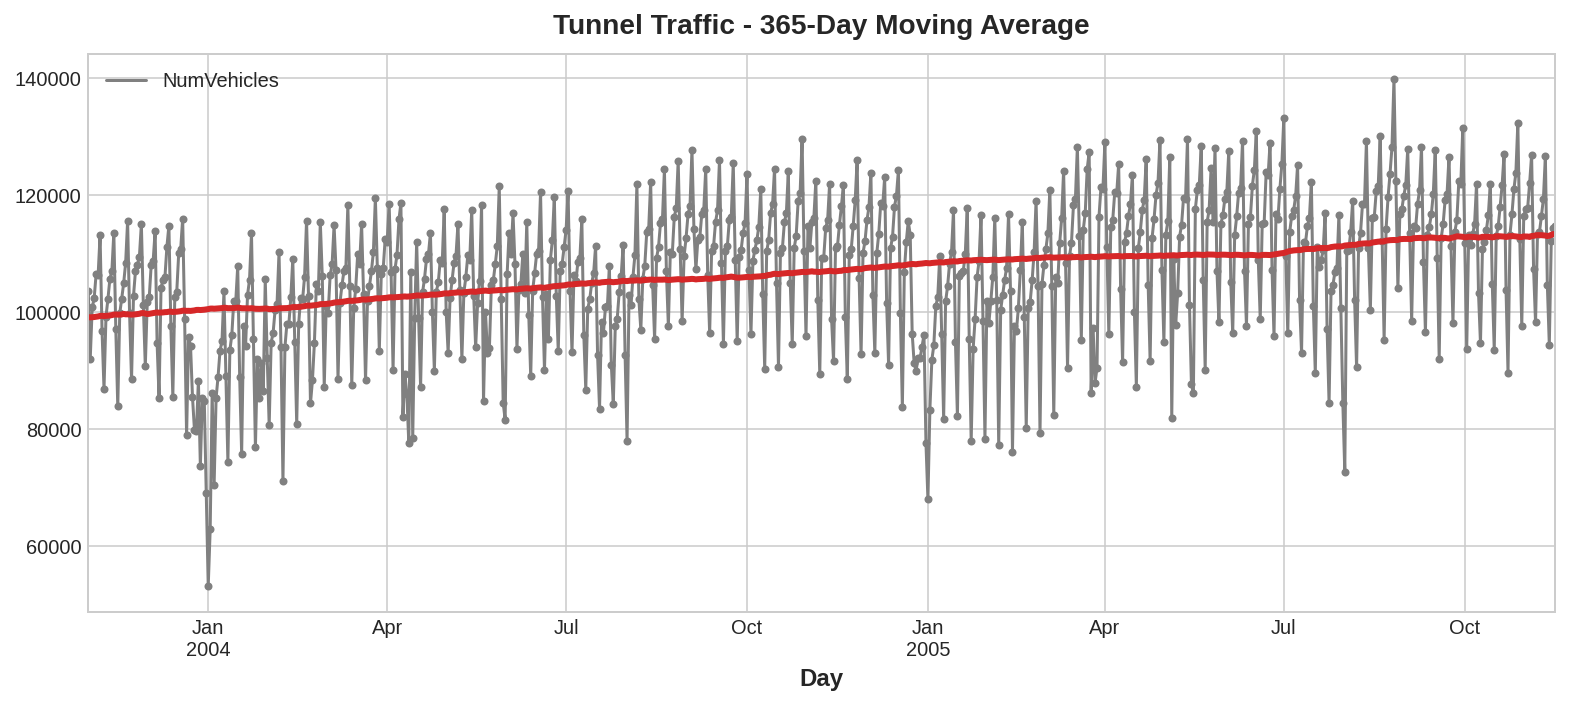

In [ ]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".-", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3,color='C3',title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

if you are unable to import deterministic process run the following command:

```!pip install --upgrade --no-deps statsmodels```

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess


dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


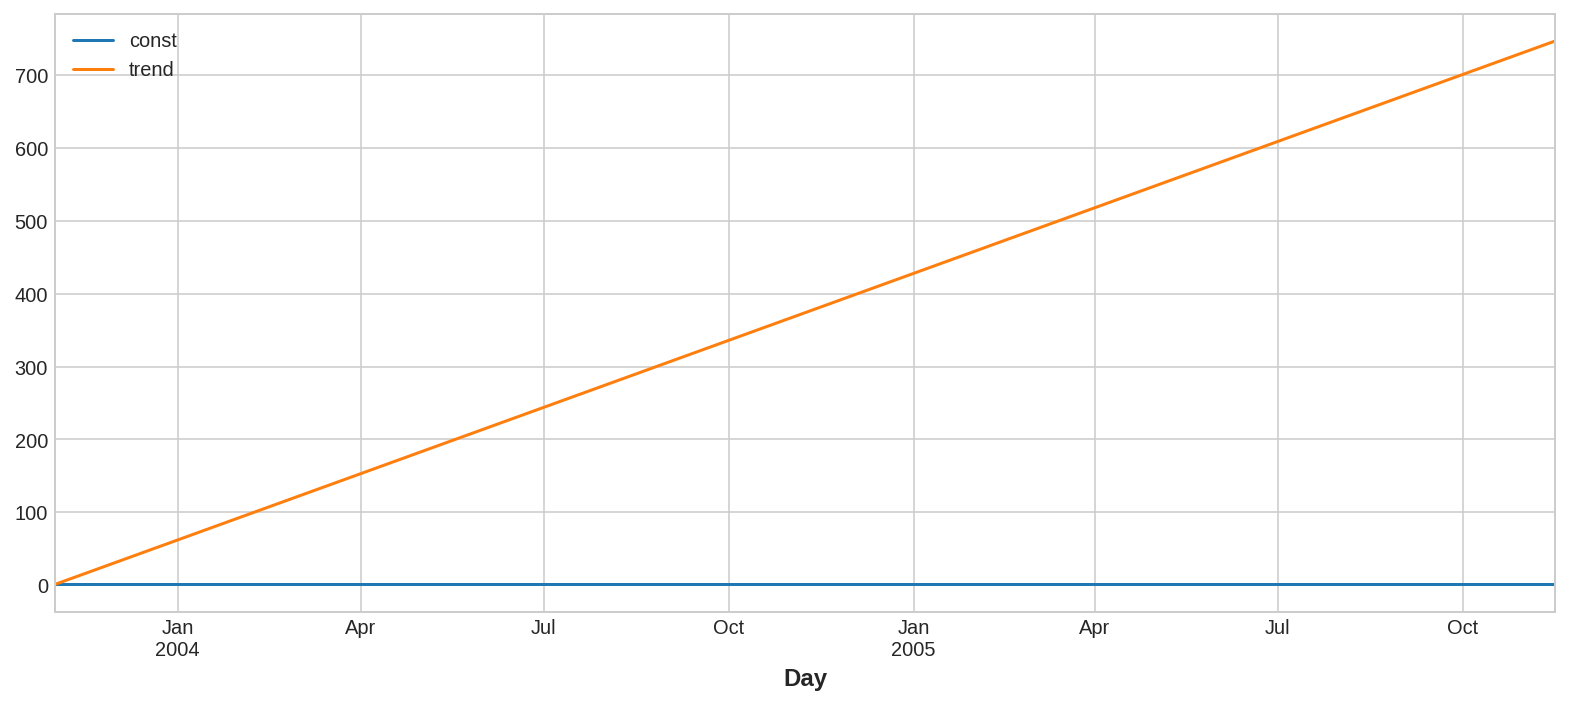

In [ ]:
X.plot() # const is the intercept 

In [ ]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target
y.head()

Day
2003-11-01    103536
2003-11-02     92051
2003-11-03    100795
2003-11-04    102352
2003-11-05    106569
Freq: D, Name: NumVehicles, dtype: int64

In [ ]:
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

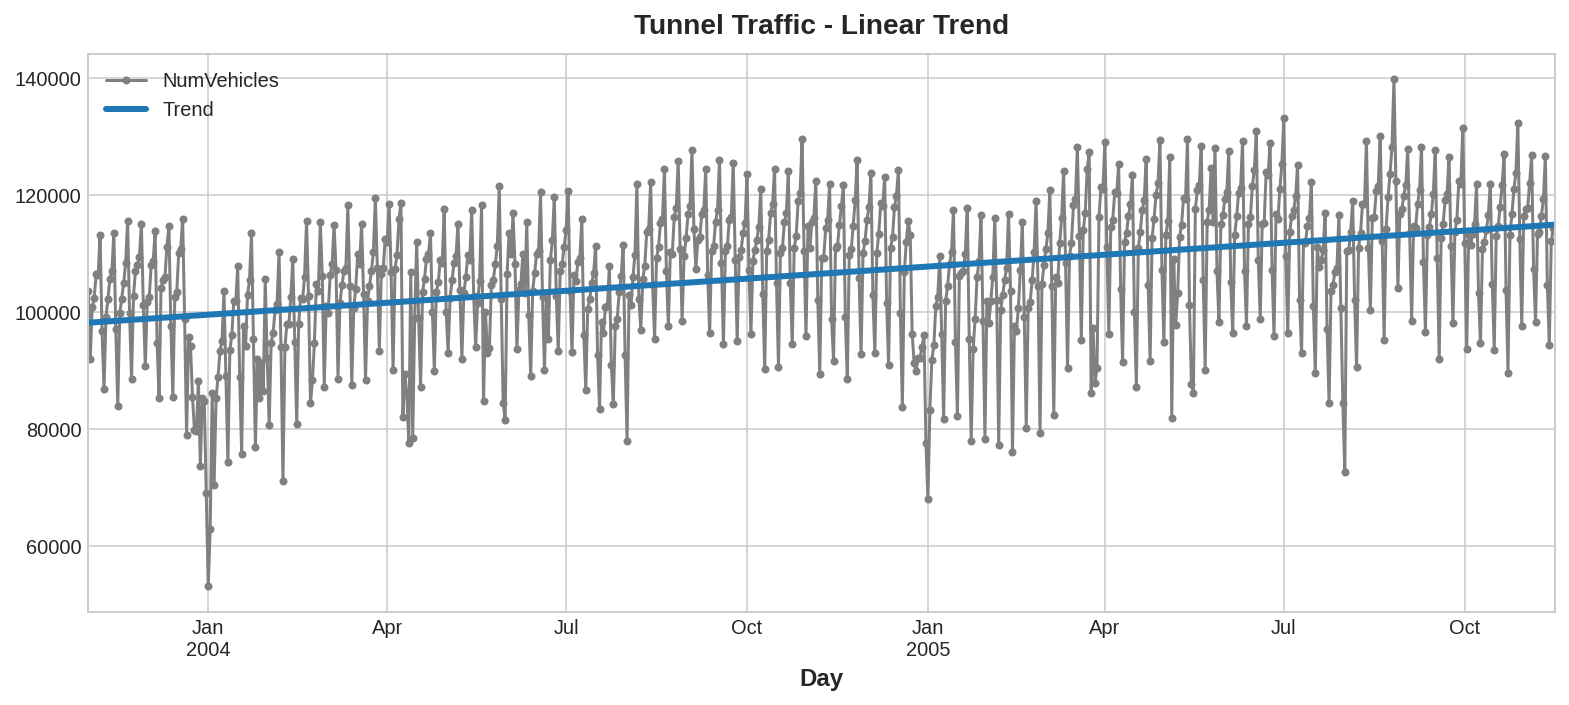

In [ ]:
ax = tunnel.plot(style=".-", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")
_ = ax.legend()

In [ ]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

In [ ]:
tunnel["2005-05":]

,NumVehicles
Day,
2005-05-01,94934
2005-05-02,113264
2005-05-03,115493
2005-05-04,126497
2005-05-05,81910
...,...
2005-11-12,104646
2005-11-13,94424
2005-11-14,112165


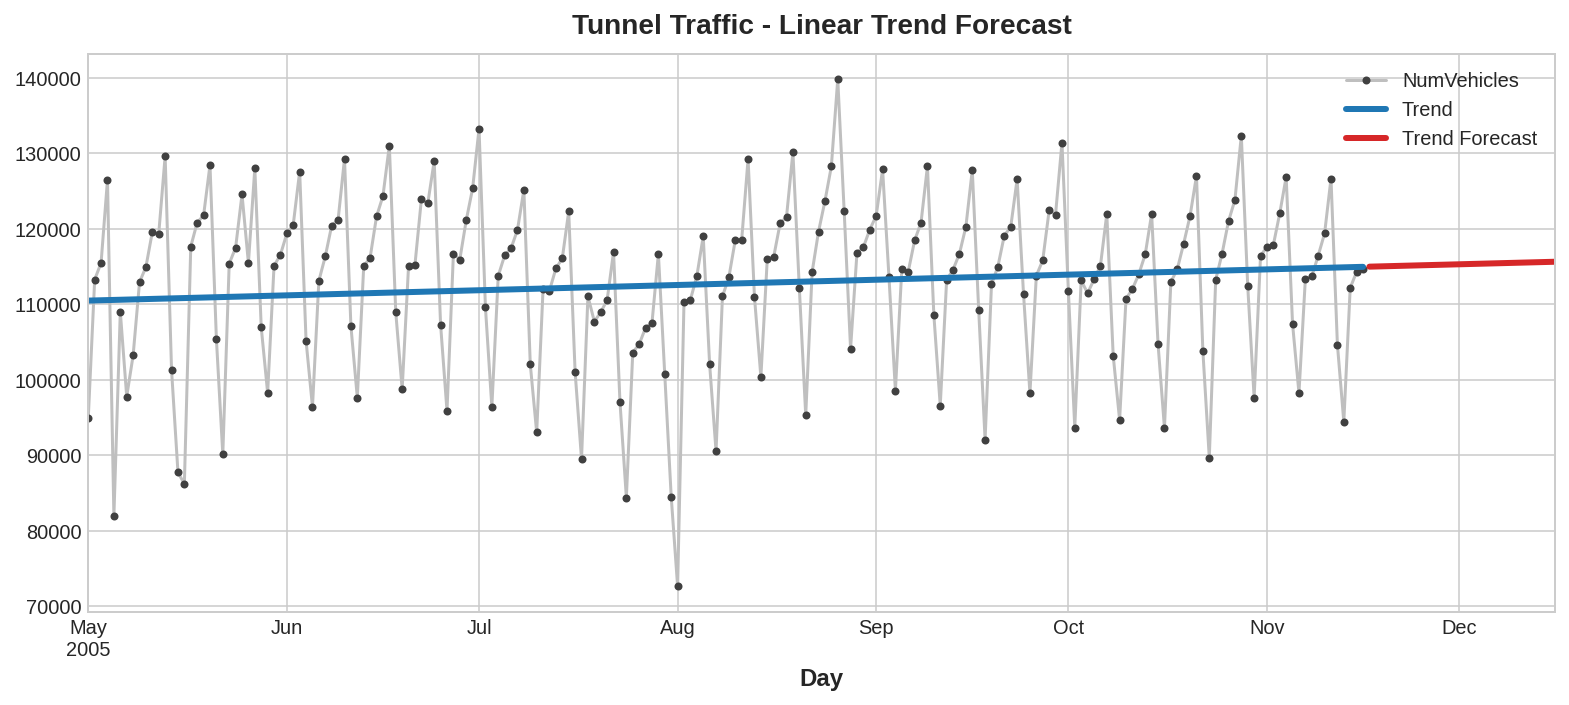

In [ ]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

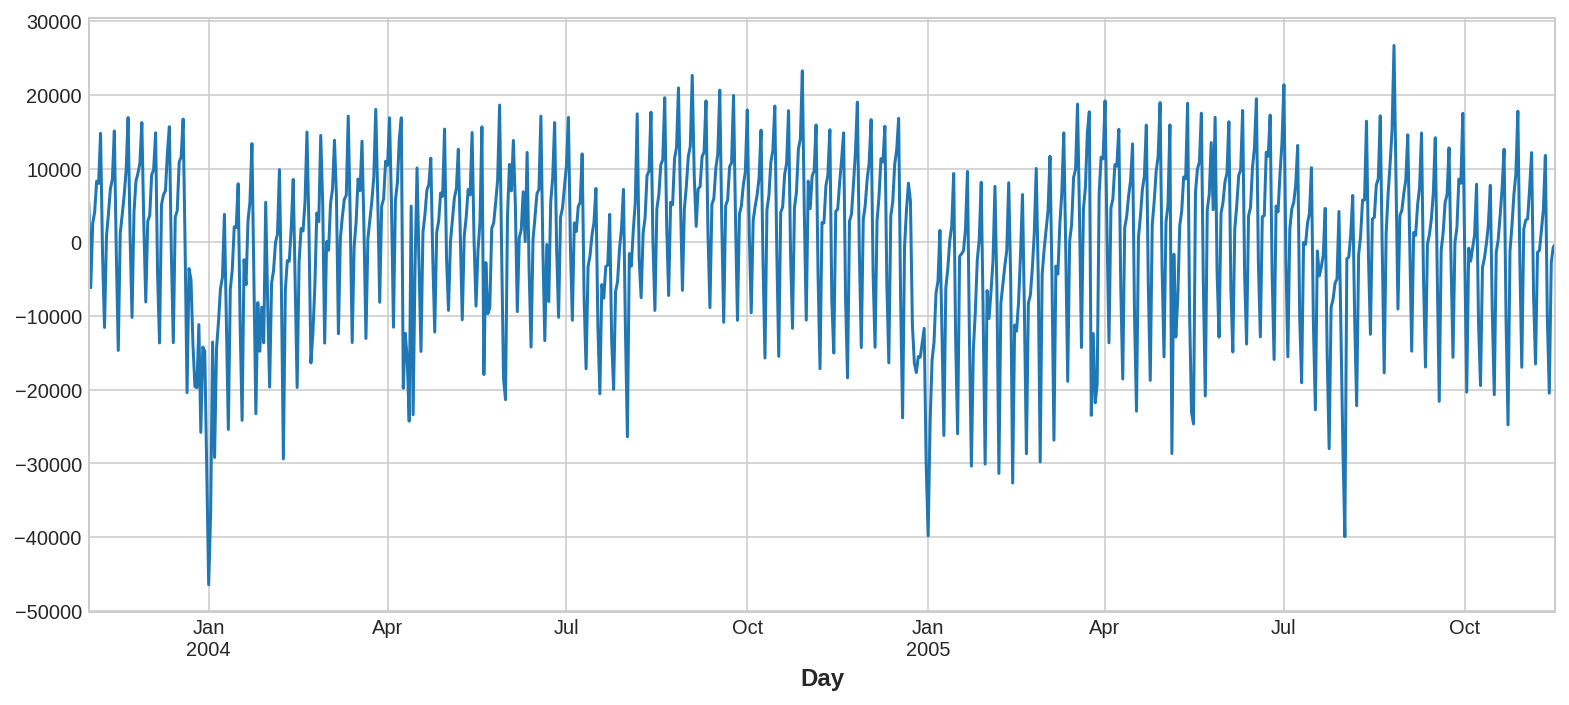

In [ ]:
detrend= y-y_pred

detrend.plot()

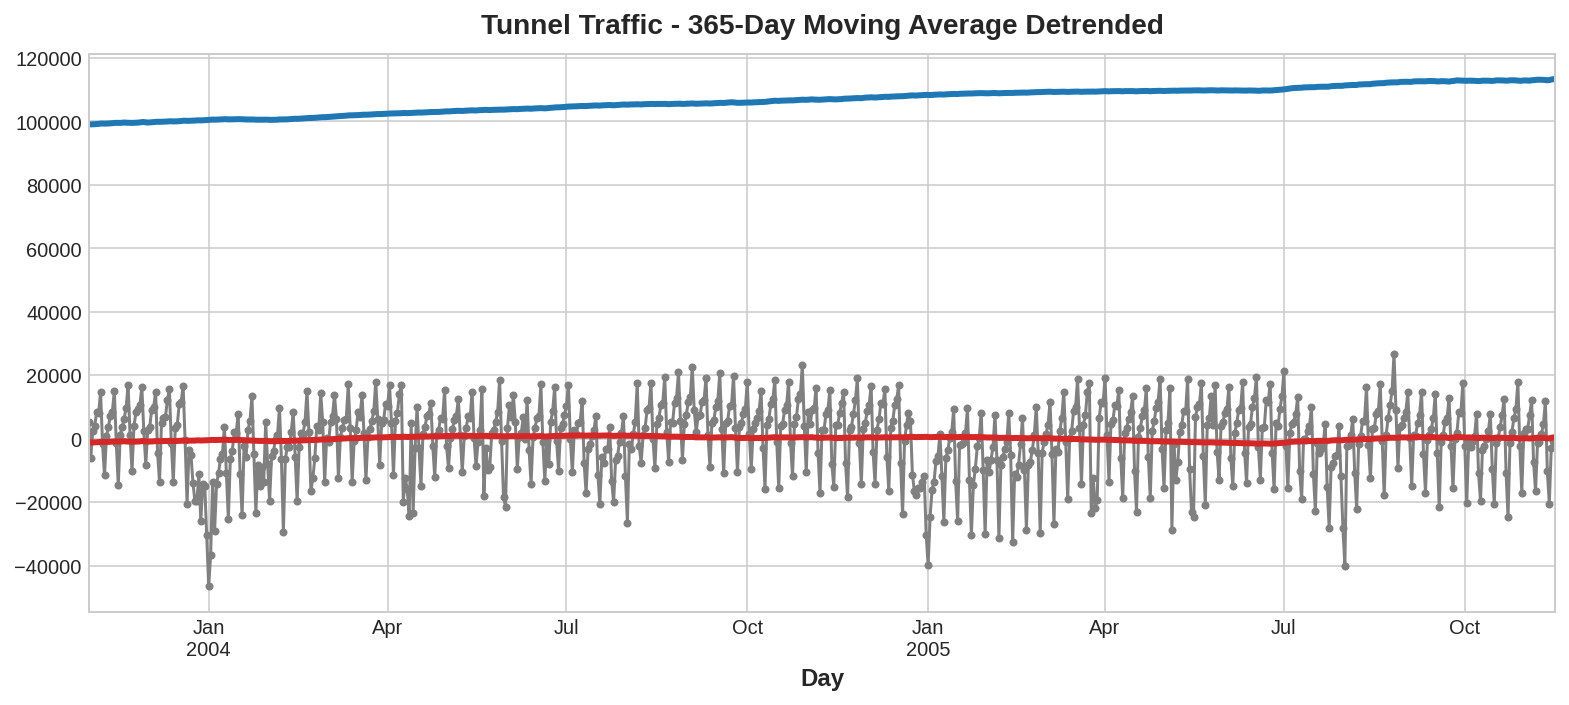

In [ ]:
moving_average_dt = detrend.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = detrend.plot(style=".-", color="0.5")
moving_average_dt.plot(
    ax=ax, linewidth=3,color='C3', legend=False,
)
moving_average.plot(
    ax=ax, linewidth=3,color='C0',title="Tunnel Traffic - 365-Day Moving Average Detrended", legend=False,
)

In [ ]:
!pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev

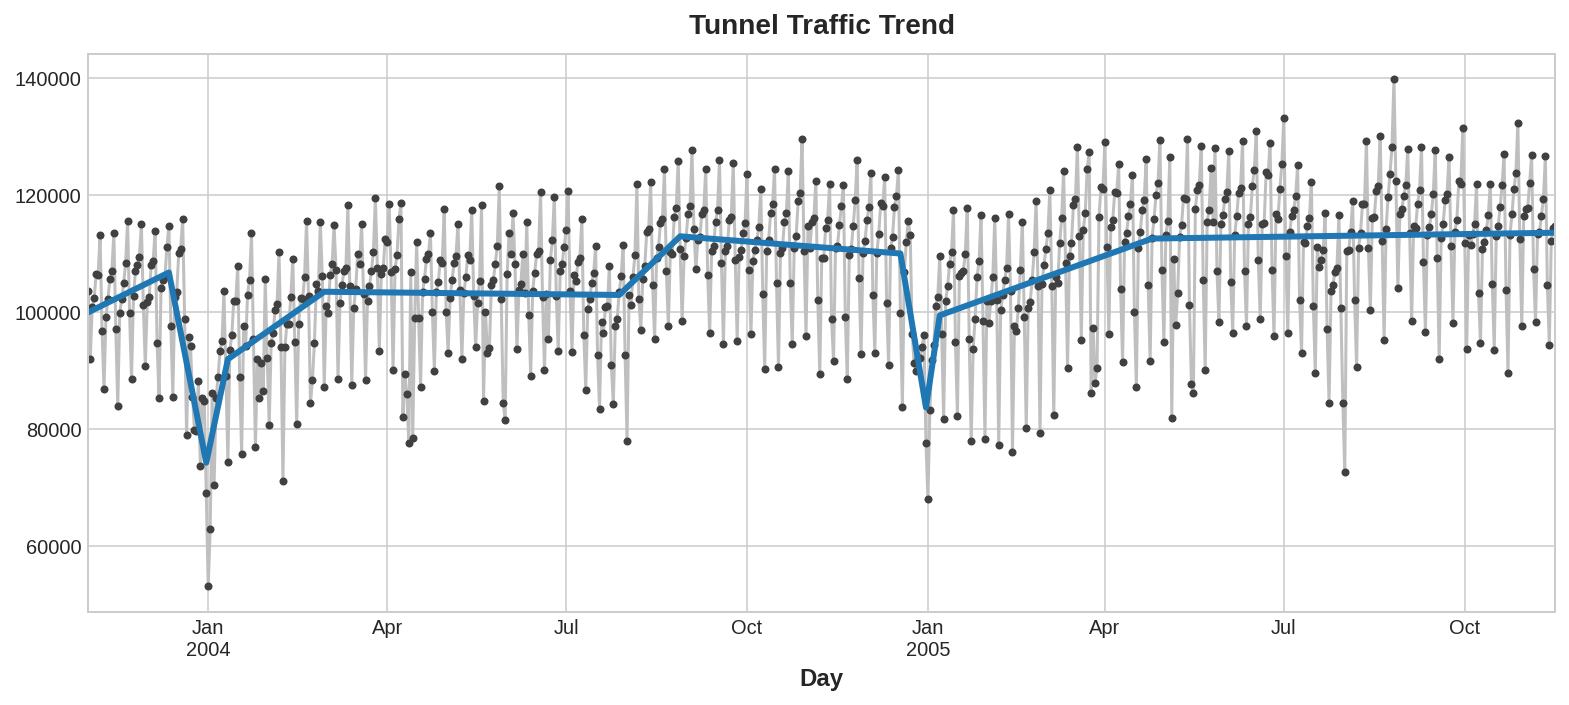

In [ ]:
from pyearth import Earth

# Target and features are the same as before
y = y.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Tunnel Traffic Trend")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [ ]:
X.head()

,trend
Day,
2003-11-01,1.0
2003-11-02,2.0
2003-11-03,3.0
2003-11-04,4.0
2003-11-05,5.0


In [ ]:
y.head()

Day
2003-11-01    103536
2003-11-02     92051
2003-11-03    100795
2003-11-04    102352
2003-11-05    106569
Freq: D, Name: NumVehicles, dtype: int64

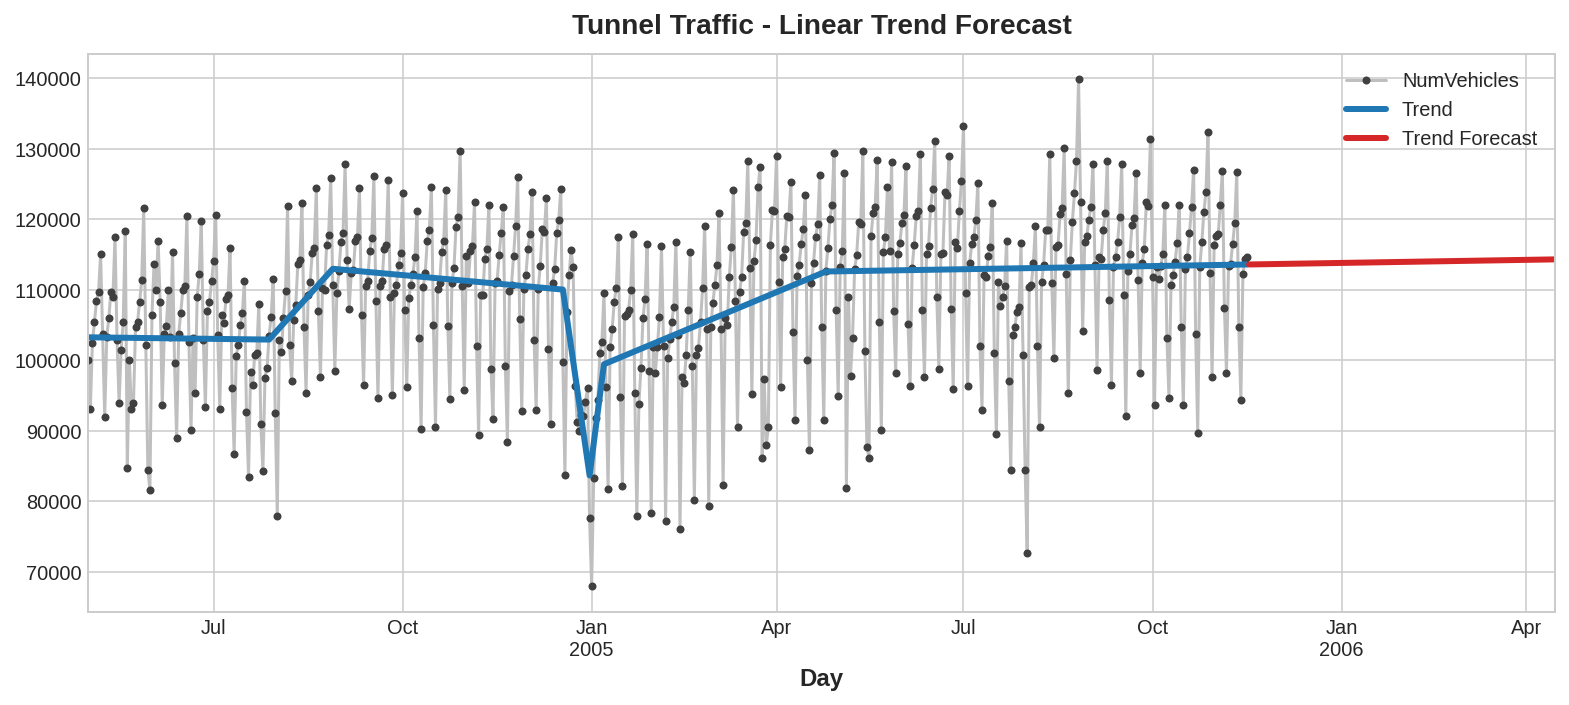

In [ ]:
X_fore=dp.out_of_sample(steps=150)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = tunnel["2004-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2004-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

In [ ]:
detrend = y - y_pred
detrend=detrend.to_frame(name="NumVehicles")
detrend.head()

,NumVehicles
Day,
2003-11-01,3575.985384
2003-11-02,-8075.184251
2003-11-03,502.646113
2003-11-04,1893.476478
2003-11-05,5944.306842


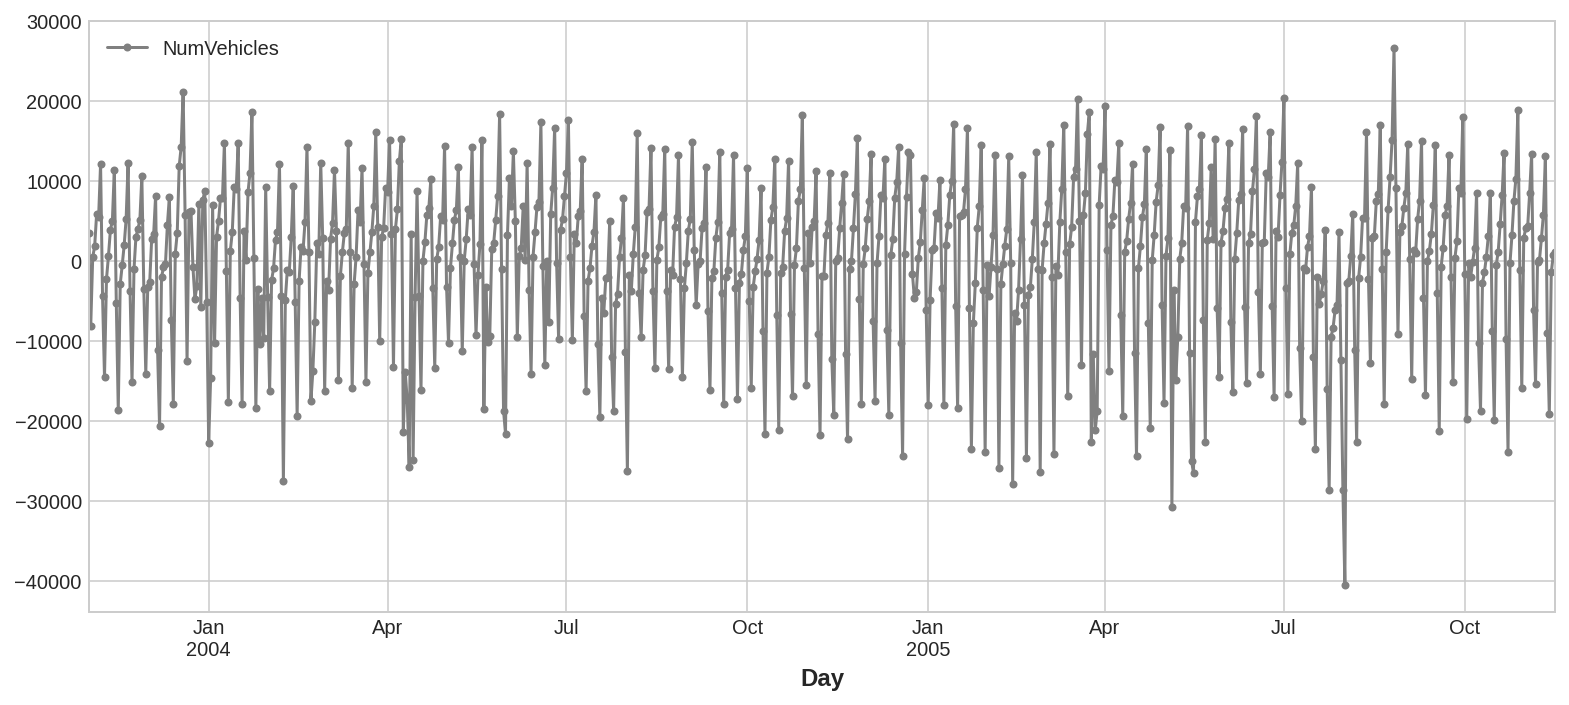

In [ ]:
detrend.plot(style='.-',color="0.50")

# **Seasonality**

In [ ]:
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [ ]:
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)
detrend["day"] = detrend.index.dayofweek  # the x-axis (freq)
detrend["week"] = detrend.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
detrend["dayofyear"] = detrend.index.dayofyear
detrend["year"] = detrend.index.year
fig, (ax0, ax1,ax2,ax3) = plt.subplots(4, 1, figsize=(11, 50))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1)
seasonal_plot(detrend, y="NumVehicles", period="week", freq="day", ax=ax2)
seasonal_plot(detrend, y="NumVehicles", period="year", freq="dayofyear", ax=ax3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X

,NumVehicles,day,week,dayofyear,year
Day,,,,,
2003-11-01,103536,5,44,305,2003
2003-11-02,92051,6,44,306,2003
2003-11-03,100795,0,45,307,2003
2003-11-04,102352,1,45,308,2003
2003-11-05,106569,2,45,309,2003
...,...,...,...,...,...
2005-11-12,104646,5,45,316,2005
2005-11-13,94424,6,45,317,2005
2005-11-14,112165,0,46,318,2005


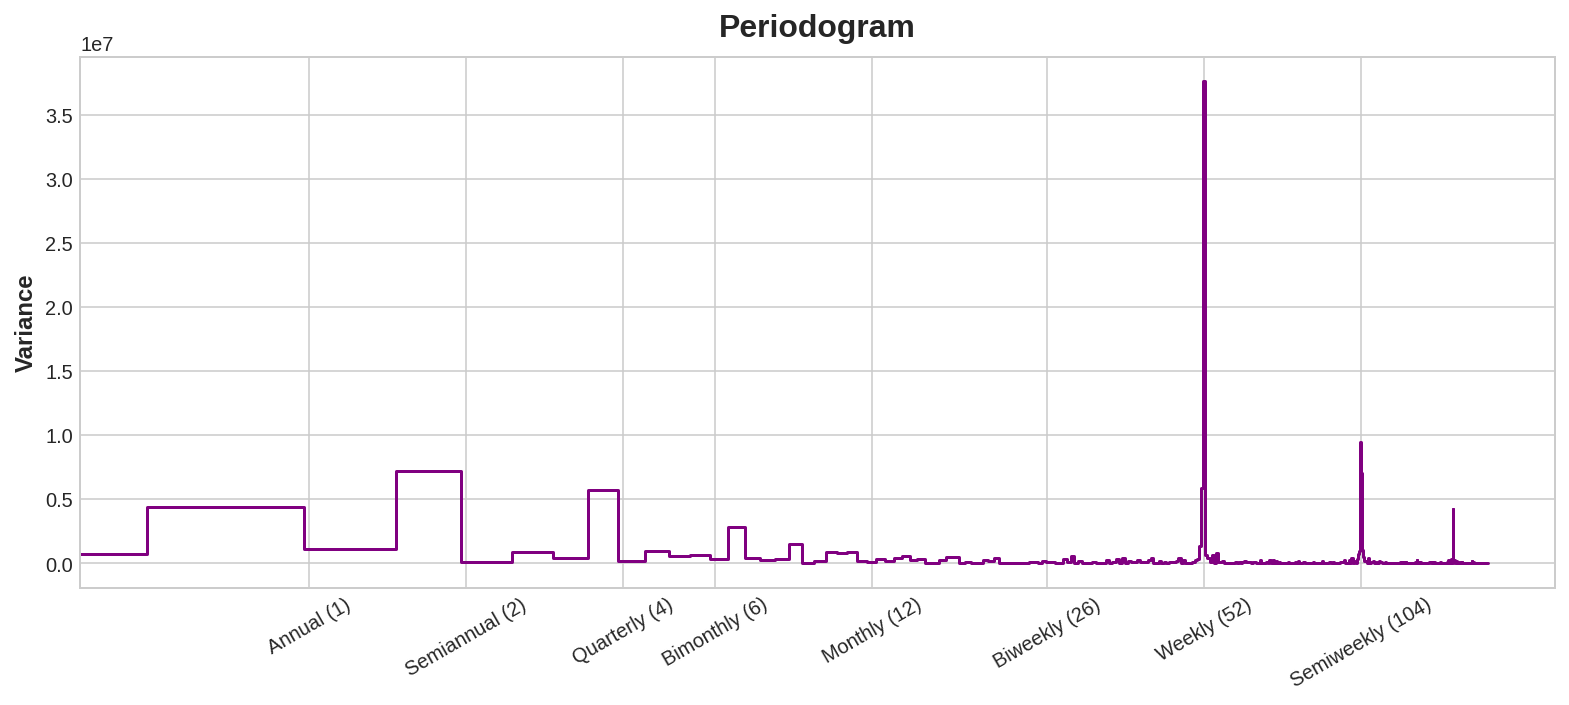

In [ ]:
plot_periodogram(tunnel.NumVehicles)

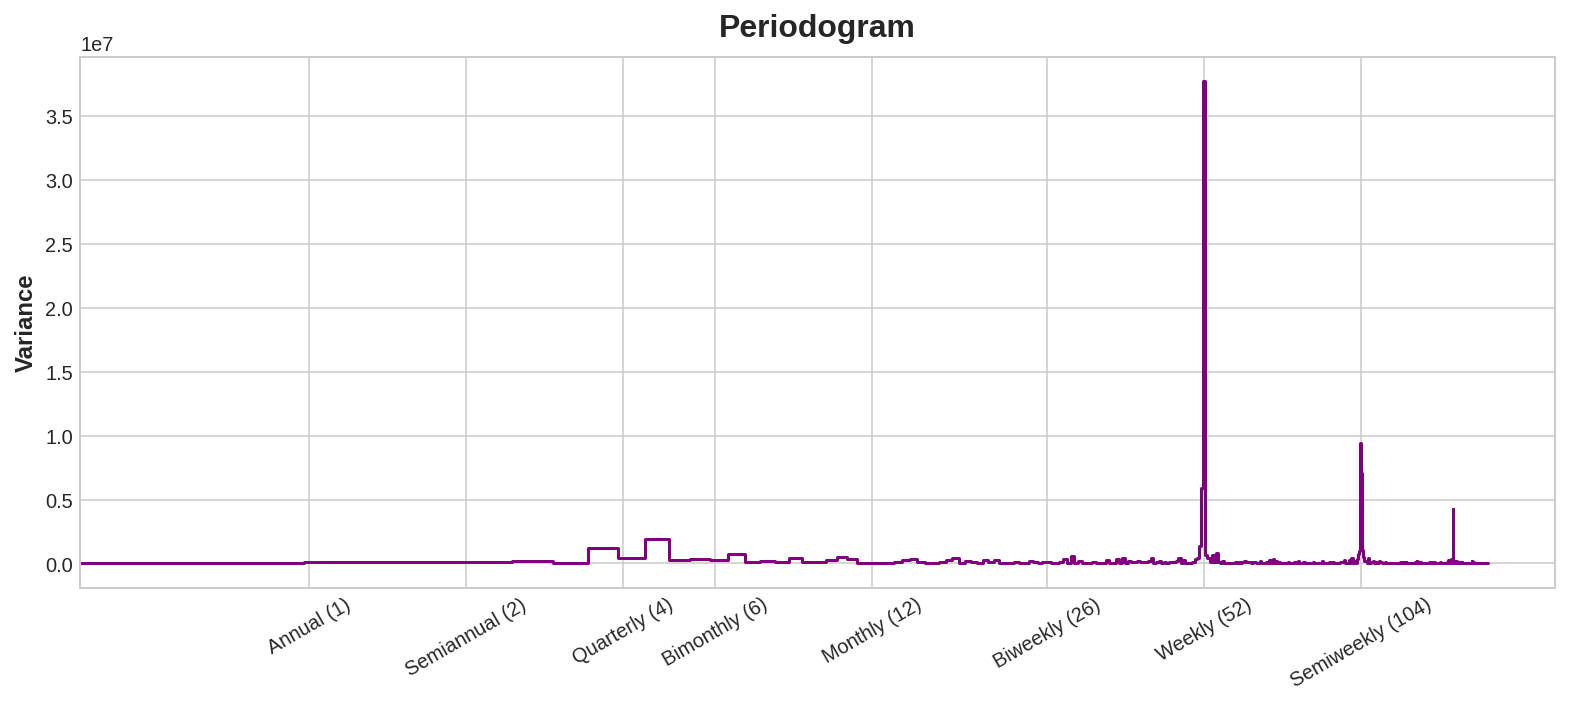

In [ ]:
plot_periodogram(detrend.NumVehicles)

In [ ]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:

fourier_features(y, freq=365.25, order=4)

,sin_365.25_1,cos_365.25_1,sin_365.25_2,cos_365.25_2,sin_365.25_3,cos_365.25_3,sin_365.25_4,cos_365.25_4
NumVehicles,,,,,,,,
103536,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
92051,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634
100795,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545
102352,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769
106569,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360
...,...,...,...,...,...,...,...,...
104646,0.196540,0.980496,0.385413,0.922744,0.559252,0.828998,0.711275,0.702914
94424,0.213377,0.976970,0.416925,0.908941,0.601269,0.799047,0.757921,0.652346
112165,0.230151,0.973155,0.447944,0.894061,0.641688,0.766966,0.800980,0.598692


In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [ ]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


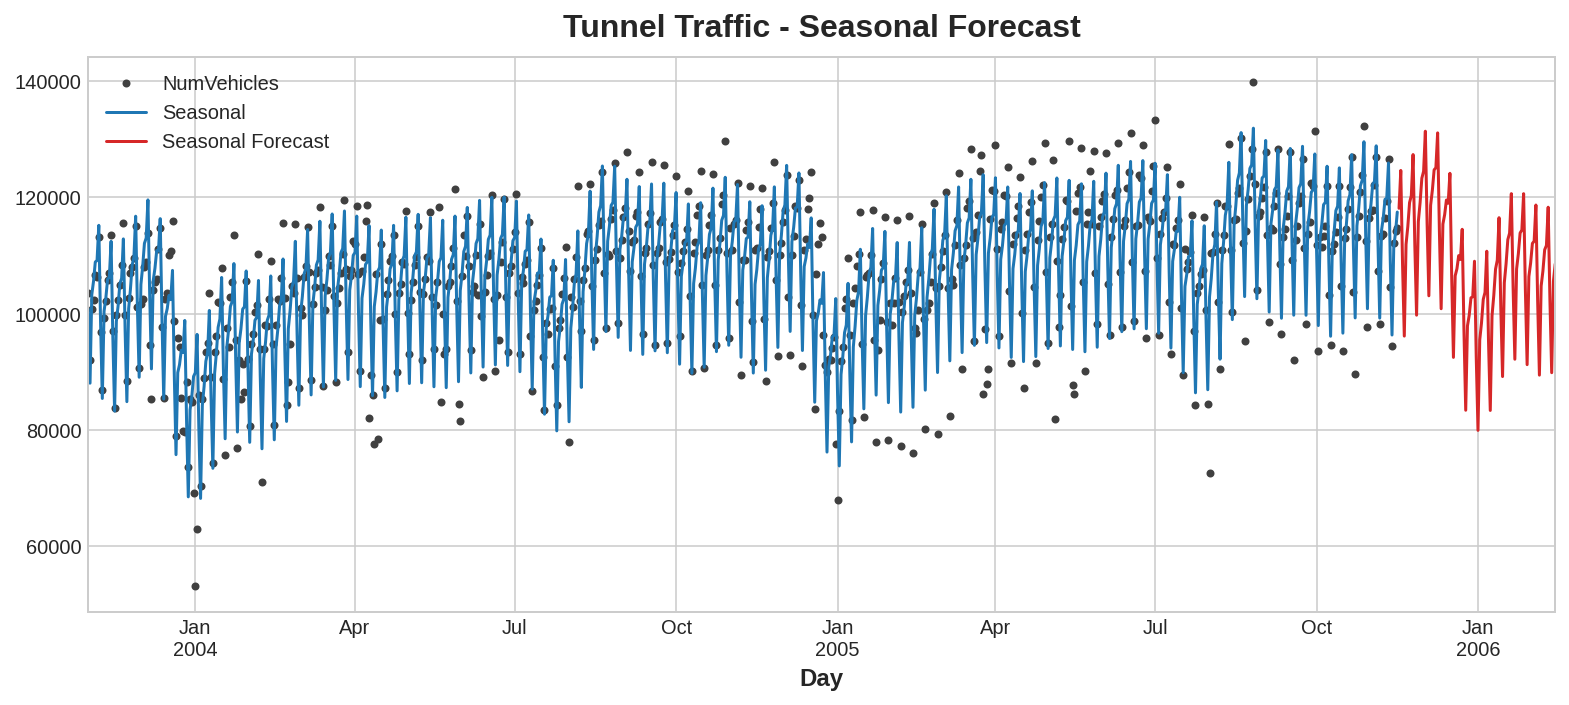

In [ ]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [ ]:
deseasoned=y - y_pred
deseasoned=deseasoned.to_frame(name="NumVehicles")
deseasoned.head()

,NumVehicles
Day,
2003-11-01,2710.393879
2003-11-02,4006.175193
2003-11-03,-2462.922484
2003-11-04,-3238.372316
2003-11-05,-2315.019433


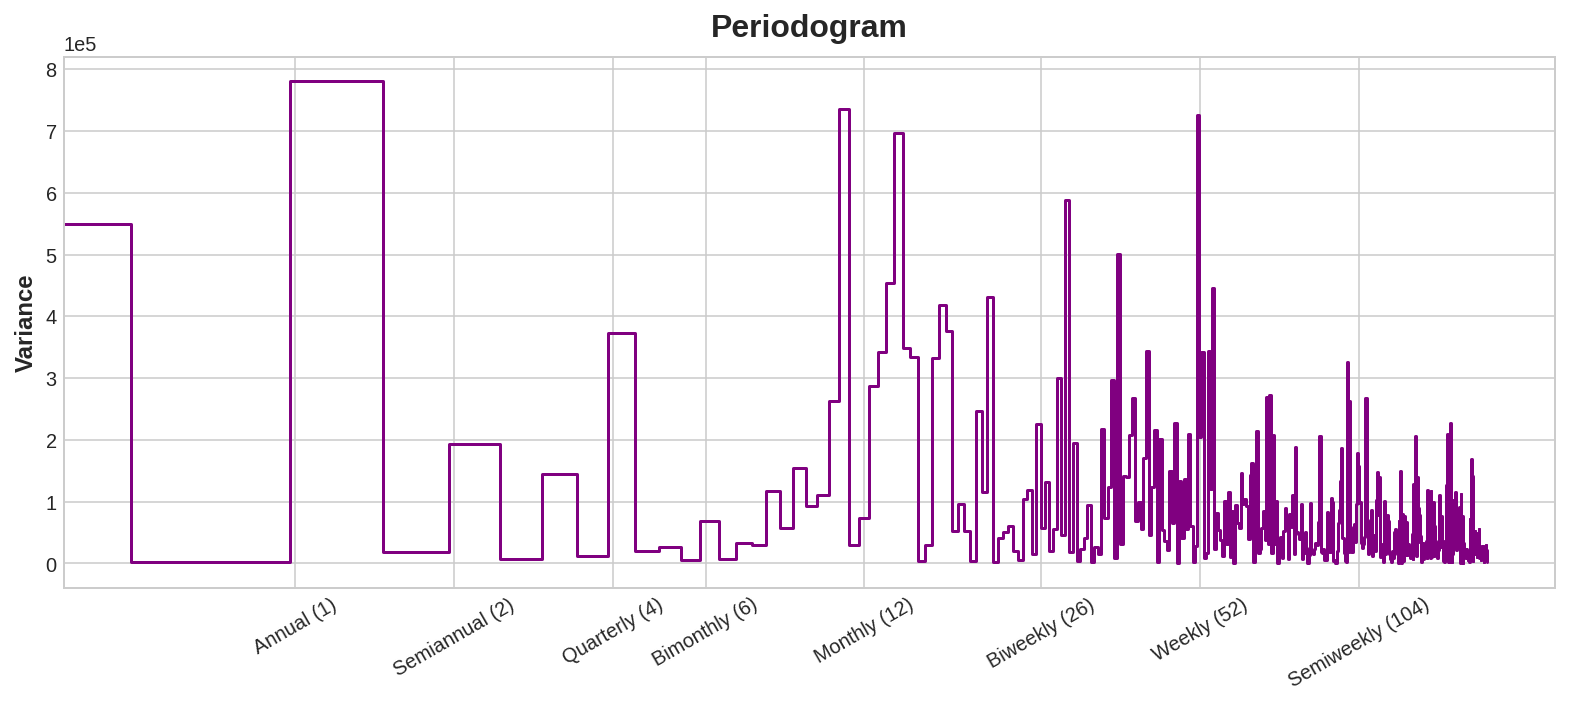

In [ ]:
plot_periodogram(deseasoned.NumVehicles)

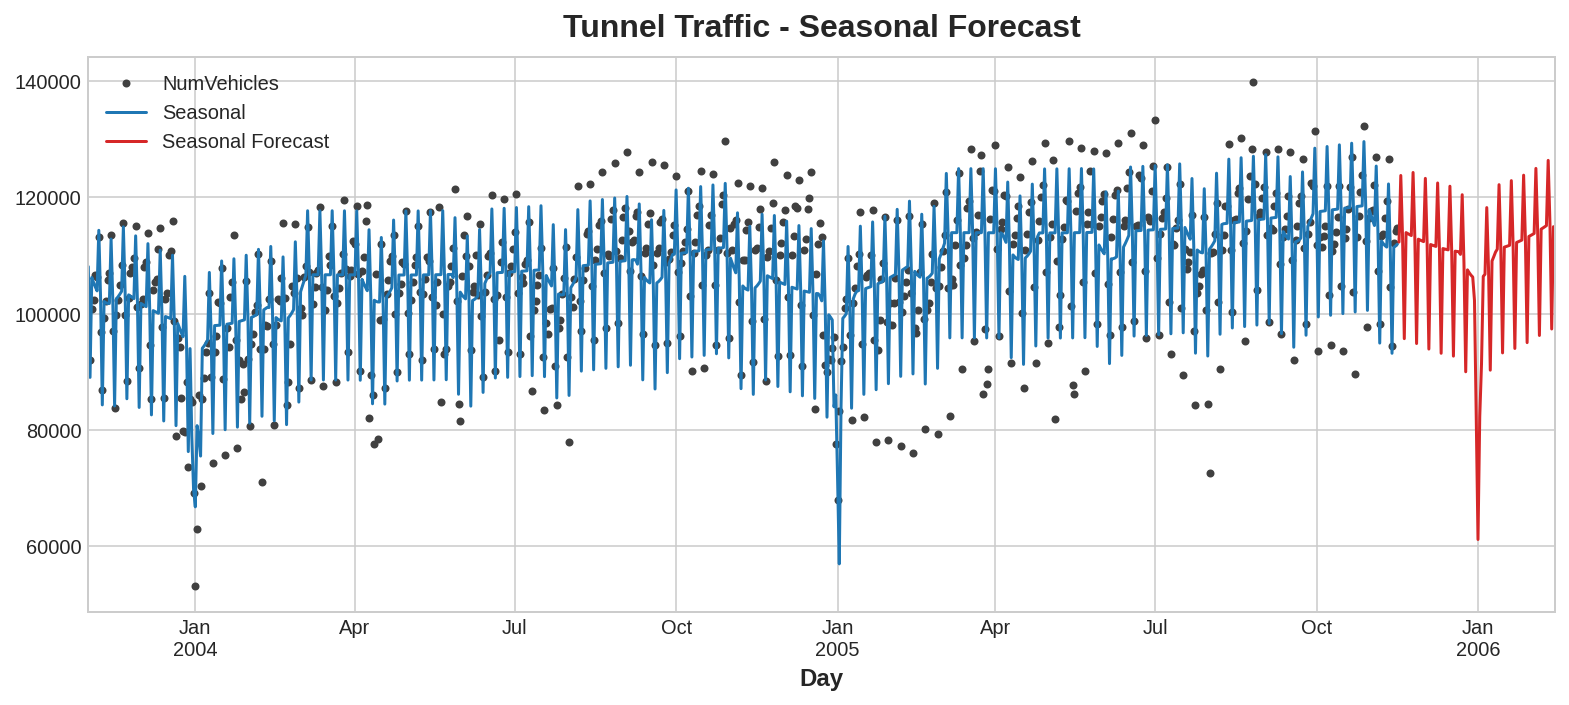

In [ ]:
earth=Earth()
earth.fit(X,y)
y_pred = pd.Series(earth.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(earth.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [ ]:
deseasoned=y - y_pred
deseasoned=deseasoned.to_frame(name="NumVehicles")
deseasoned.head()

,NumVehicles
Day,
2003-11-01,-4571.223539
2003-11-02,3012.560255
2003-11-03,-5428.761815
2003-11-04,-3026.670405
2003-11-05,1959.954982


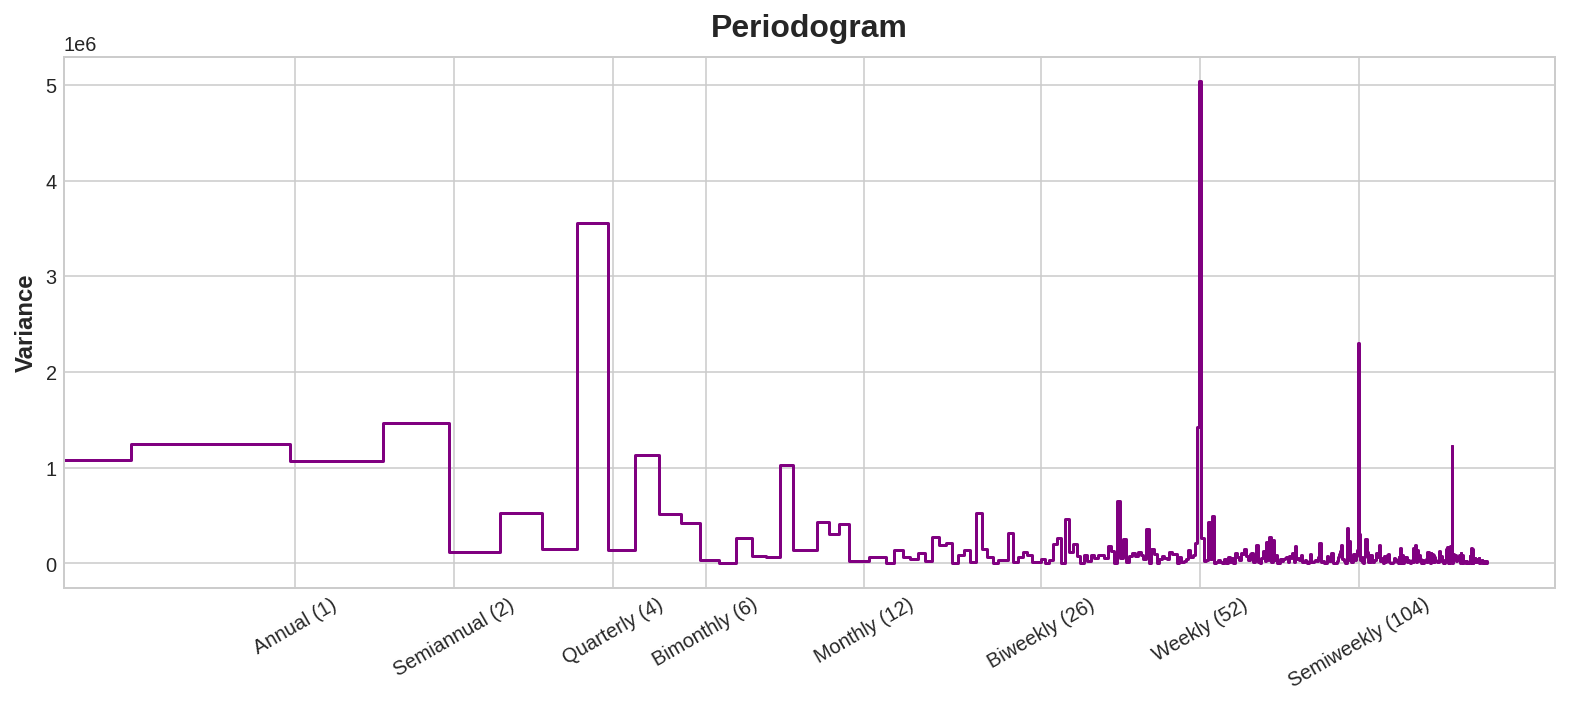

In [ ]:
plot_periodogram(deseasoned.NumVehicles)

# **Adfuller test (ADF)**
To check stationarity in the data we use adfuller test.
If the p-value is more than 0.05 than the data is non-stationary. This is also called the null hypothesis testing.

$H_0=\text{The data is non-stationary if $p>0.05$}$

$H_1 =\text{The data is stationary if $p<0.05$}$


In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(tunnel.NumVehicles.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.280423
p-value: 0.178360


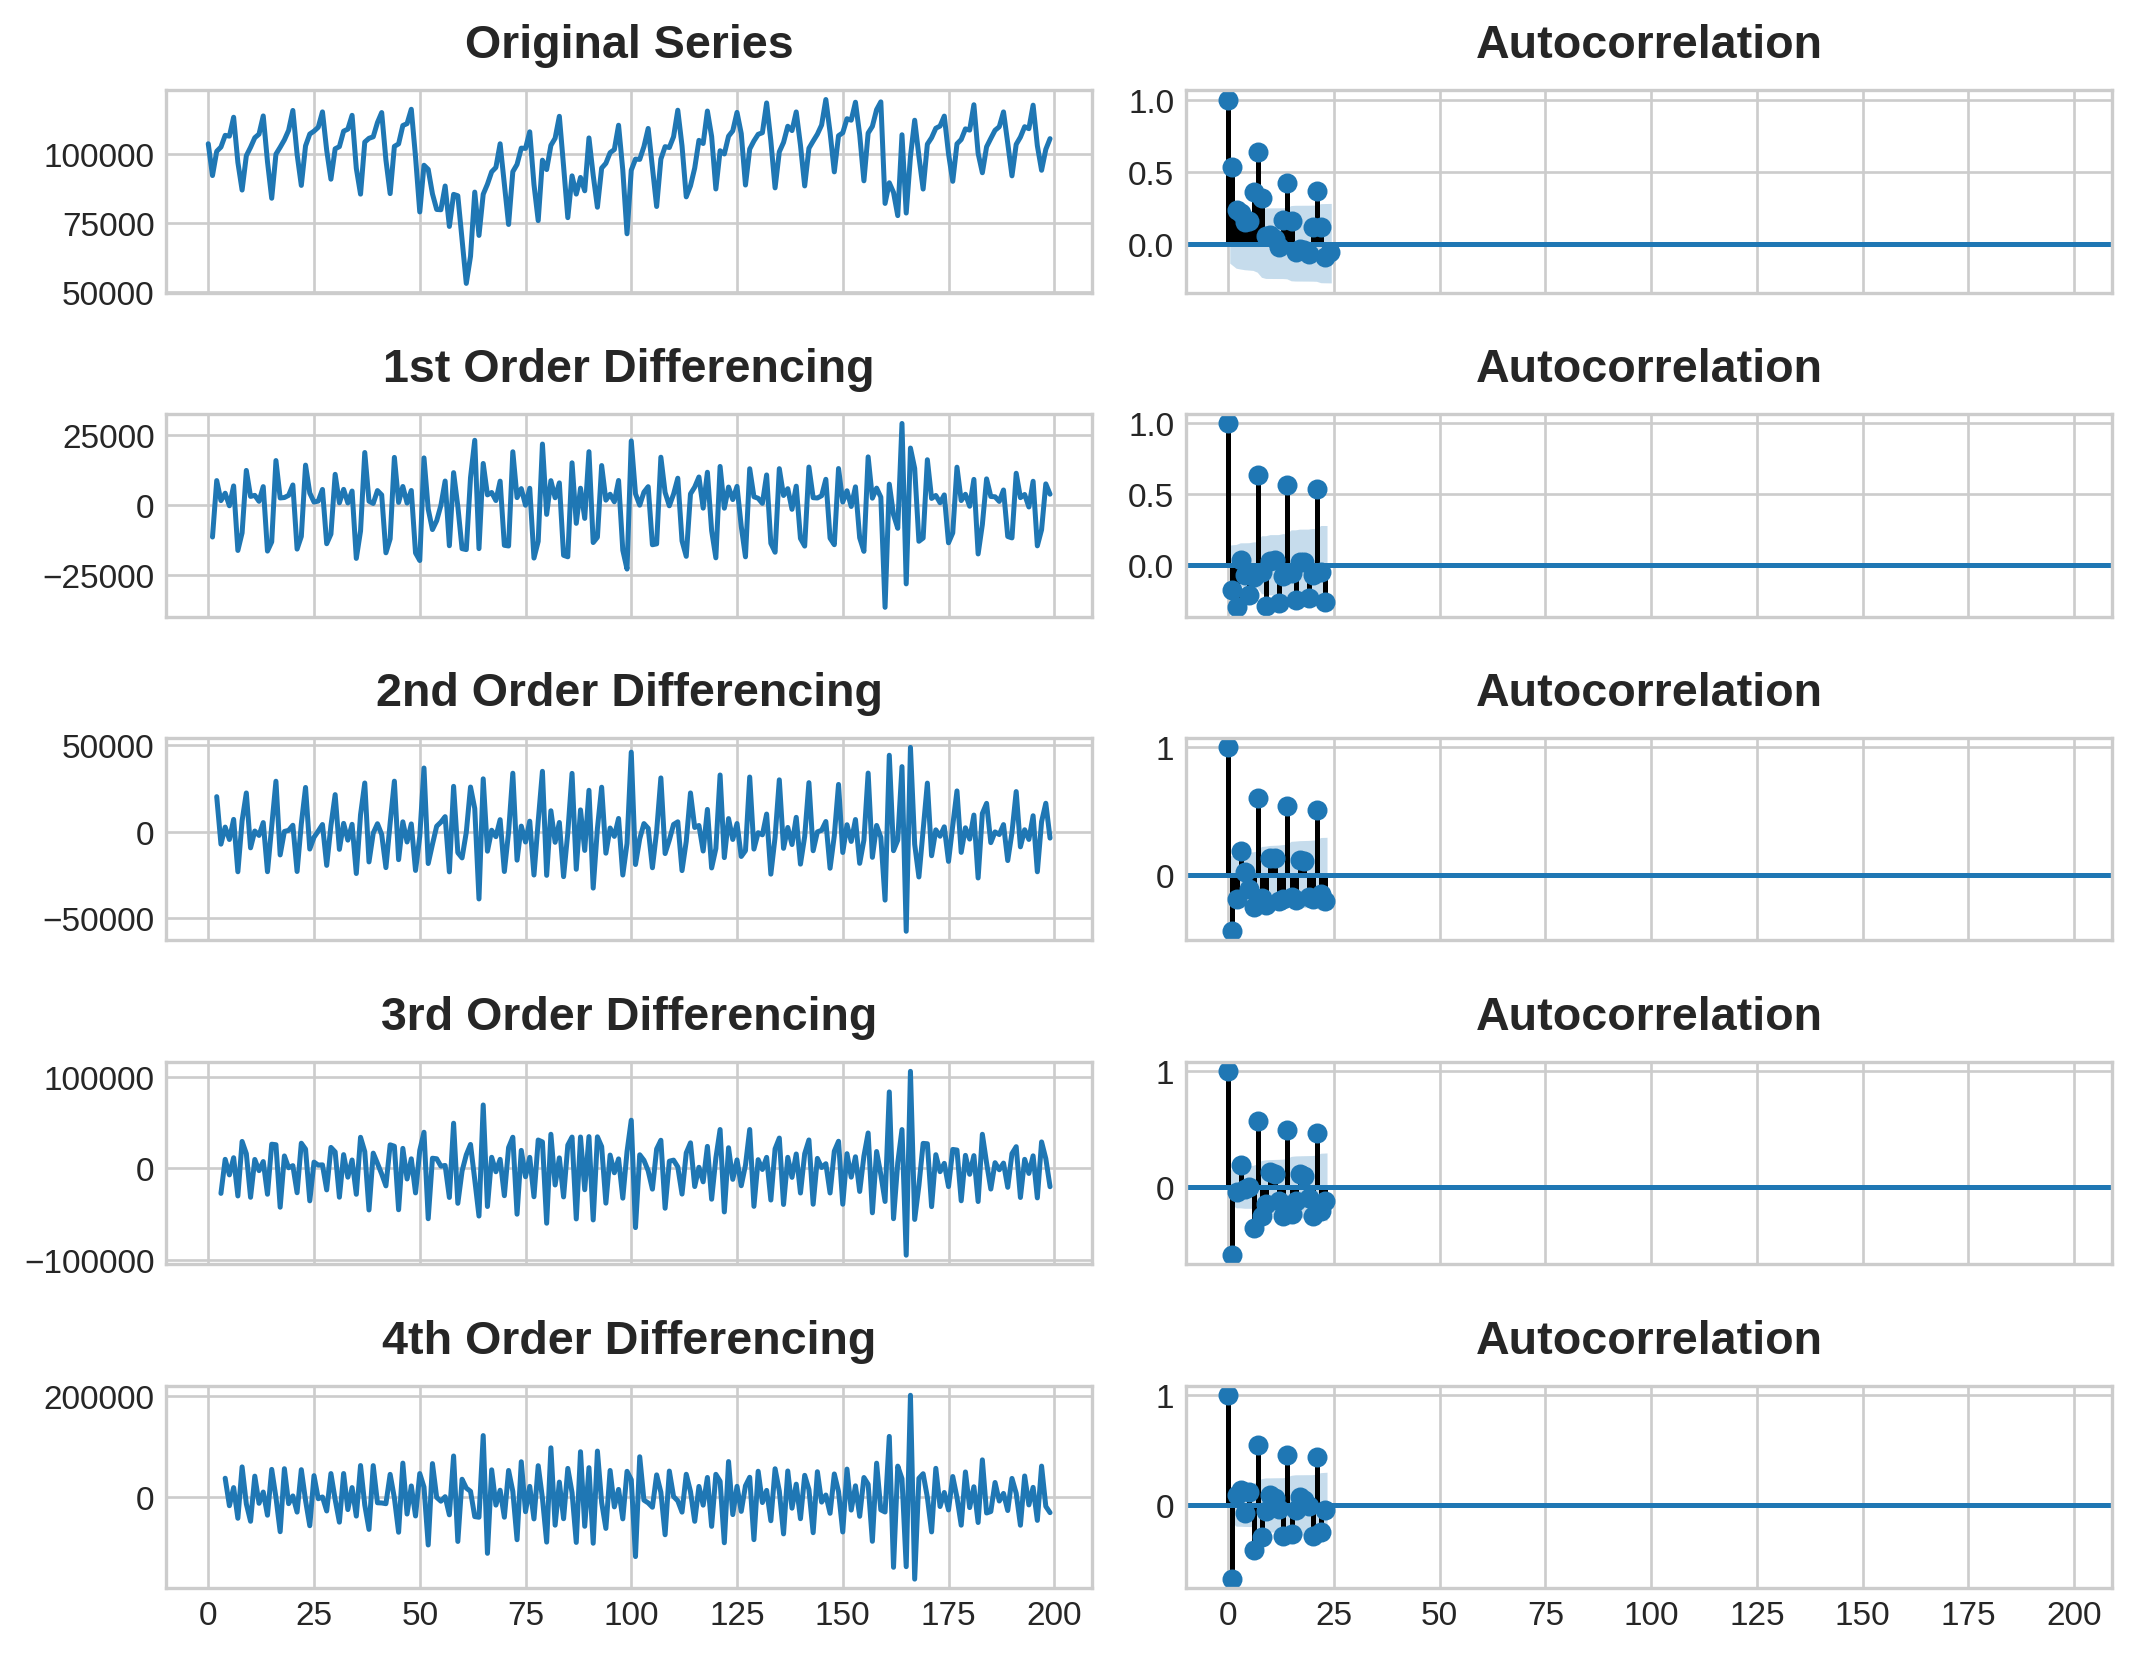

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df=tunnel1[0:200]
# Original Series
fig, axes = plt.subplots(5, 2, sharex=True)
axes[0, 0].plot(df.NumVehicles); axes[0, 0].set_title('Original Series')
plot_acf(df.NumVehicles, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.NumVehicles.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.NumVehicles.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.NumVehicles.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.NumVehicles.diff().diff().dropna(), ax=axes[2, 1])

axes[3, 0].plot(df.NumVehicles.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(df.NumVehicles.diff().diff().diff().dropna(), ax=axes[3, 1])

axes[4, 0].plot(df.NumVehicles.diff().diff().diff().diff()); axes[4, 0].set_title('4th Order Differencing')
plot_acf(df.NumVehicles.diff().diff().diff().diff().dropna(), ax=axes[4, 1])

plt.show()

# **Partial Autocorrelations**

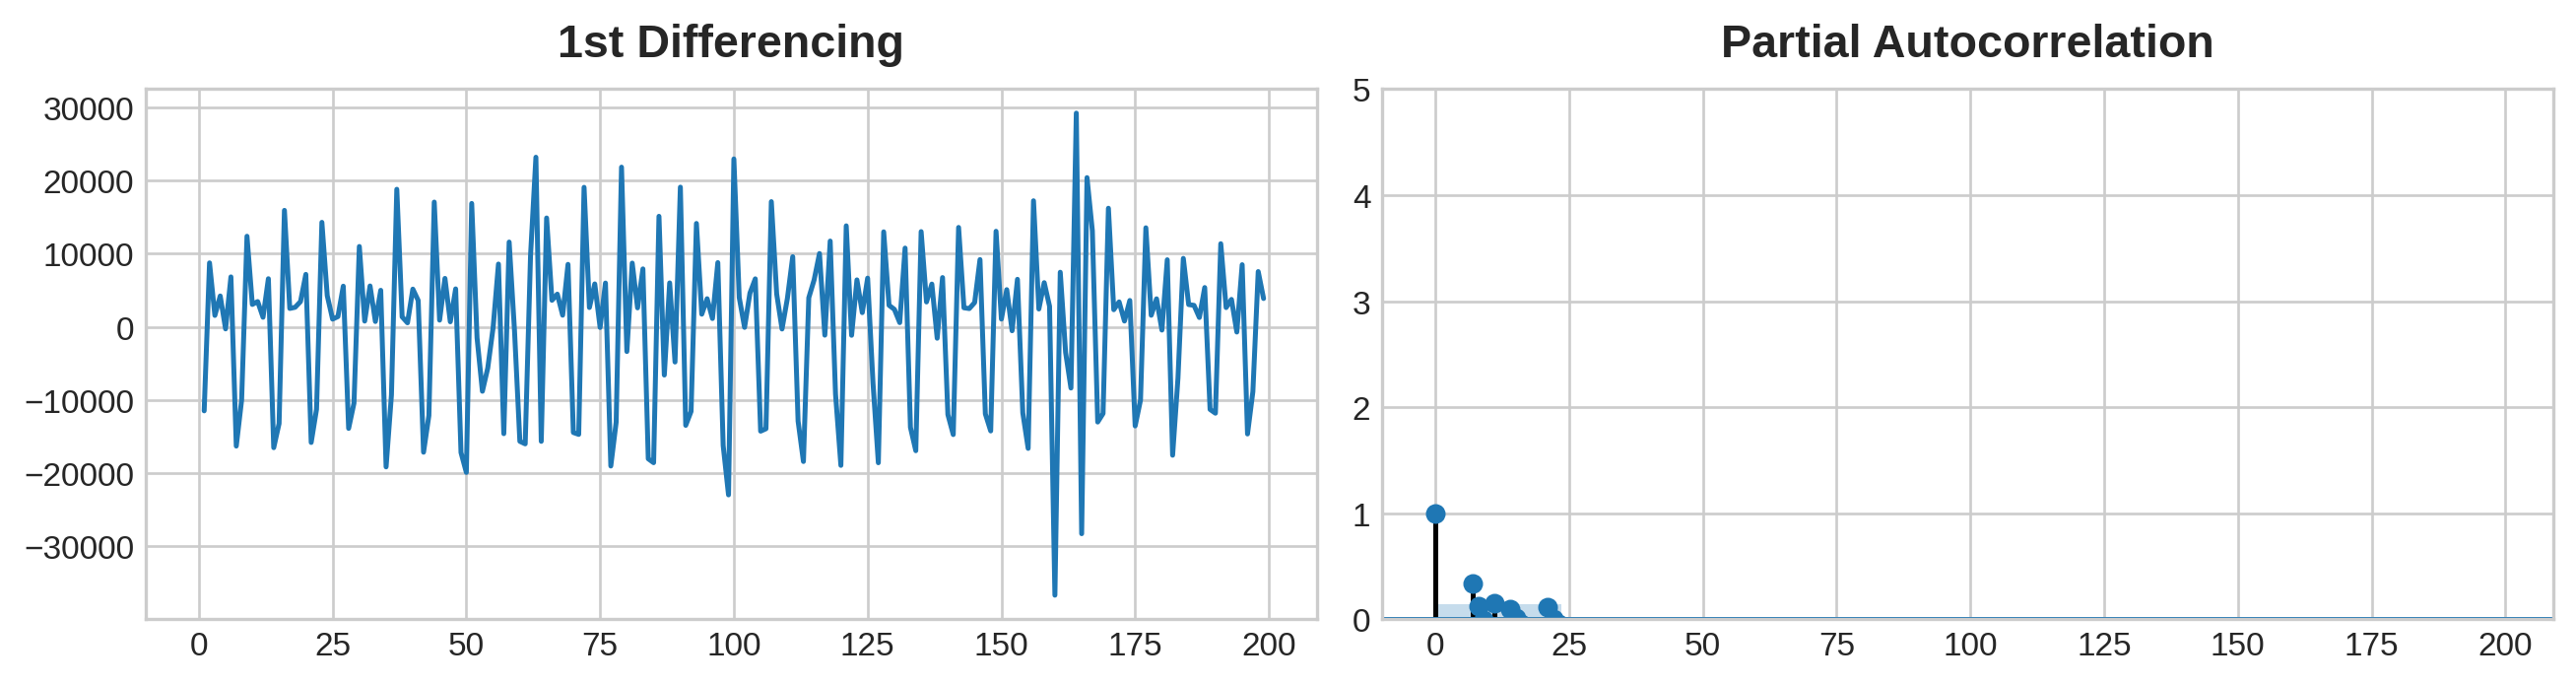

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(11,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.NumVehicles.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.NumVehicles.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
y=tunnel['NumVehicles']

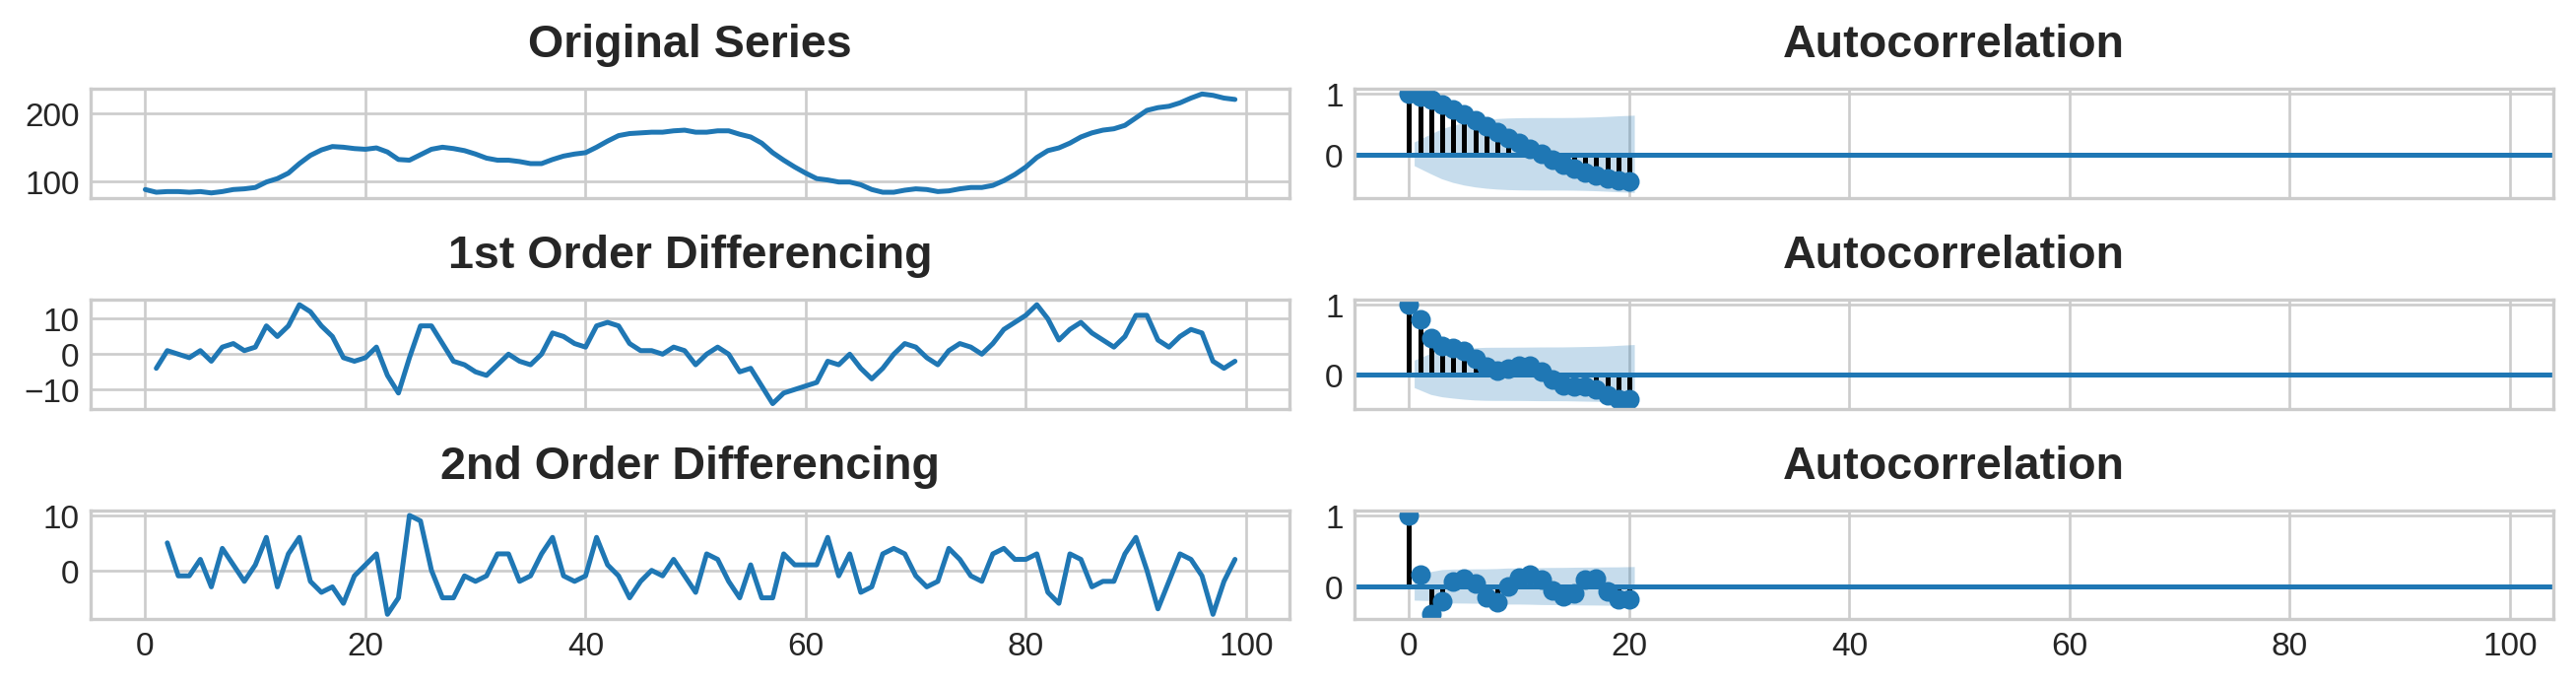

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
df.value.diff().head()

0    NaN
1   -4.0
2    1.0
3    0.0
4   -1.0
Name: value, dtype: float64

In [ ]:
df.value.head()

0    88
1    84
2    85
3    85
4    84
Name: value, dtype: int64